In [92]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter, defaultdict
import re
from IPython.display import display 
from csv import QUOTE_NONE 

In [2]:
SAM_COL_NAMES = ['QNAME', 'FLAG', 'RNAME', 'POS', 'MAPQ', 'CIGAR', 'RNEXT', 'PNEXT', 'TLEN', 'SEQ', 'QUAL', 'TAGS']

In [160]:
def read_data(ref_path, sam_path, skiprows=2):
    ref = ''
    with open(ref_path, 'r') as fi:
        for line in fi:
            if line[0] != '>':
                ref += line.strip()
    ref_len = len(ref)
    
    sam = pd.read_csv(sam_path, sep='\t', skiprows=skiprows, quoting=QUOTE_NONE, names=SAM_COL_NAMES)
    sam['seq_len'] = sam['SEQ'].apply(len)
    return ref, ref_len, sam

In [72]:
def qual(c, quality_offset=33):
    return ord(c) - quality_offset

In [176]:
def stats(L):
    if isinstance(L, np.ndarray):
        A = L
    else:
        A = np.array(L)
        
    if len(A) == 0:
        print('(пусто)')
        return

    _mean = np.mean(A)
    _std = np.std(A)
    print(f'Среднее {_mean:.1f}')
    print(f'Среднеквадратичное отклонение {_std:.1f}')
    print(f'Минимум {np.min(A)}, максимум {np.max(A)}')
    print(f'Интервал, в который попадает 95% [{_mean - 2*_std:.1f}, {_mean + 2*_std:.1f}]')

In [153]:
def coverage(sam, ref_len):
    cover = np.zeros(ref_len)
    for i in sam.index:
        if sam.loc[i, 'POS'] > 0:
            for j in range(sam.loc[i, 'POS'], sam.loc[i, 'POS'] + sam.loc[i, 'seq_len']):
                if j < ref_len:
                    cover[j-1] += 1
    cover_1000 = [np.mean(cover[i:i+1000]) for i in range(0, ref_len, 1000)]
    
    plt.plot(cover_1000)
    plt.grid(alpha=0.75)
    plt.xlabel('Reference position (thousands of nucleotides)')
    plt.ylabel('Number of reads')
    plt.title('Coverage')
    plt.show()
    
    print(f'Среднее покрытие: {np.mean(cover):.1f}')
    print(f'Доля покрытой области генома {sum(cover > 0)/ref_len*100:.1f}%')

In [168]:
def inserts(sam, iq_range=0.98):
    insert_sizes = abs(np.array(sam['TLEN']))
    pcnt = (1 - iq_range)/2
    insert_sizes = sam['TLEN'].apply(abs)
    qlow, median, qhigh = insert_sizes.quantile([pcnt, 0.50, 1-pcnt])
    iqr = qhigh - qlow
    filtered = insert_sizes[ (insert_sizes - median).abs() <= iqr]
    
    plt.hist(filtered, bins=50, rwidth=0.85)
    plt.grid(axis='y', alpha=0.75)
    plt.xlabel('Insert sizes')
    plt.ylabel('Number of reads')
    plt.title('Insert sizes distribution')
    plt.show()
    
    
    print('Расстояние вставки')
    stats(filtered)

In [184]:
def errors(sam, ref):
    errors_count = defaultdict(Counter)
    indels = []
    qual_mismatch = []
    qual_insert = []
    indels_n = 0
    indels_poly = 0
    
    for n in sam.index:
        pos = sam.loc[n, 'POS']
        if pos == 0 or sam.loc[n, 'CIGAR'] == '*':
            continue
        
        read_seq = sam.loc[n, 'SEQ']
        read_qual = sam.loc[n, 'QUAL']
        cigar = re.findall(r'(\d+)([MIDNSHP=X])', sam.loc[n, 'CIGAR'])
        seq_aligned = ''
        
        i = 0
        j = 0
        for cig_len, cig_ch in cigar:
            if cig_ch in 'DI':
                indels.append(int(cig_len))
                
            for _ in range(int(cig_len)):
                if cig_ch == 'M':
                    # match or mismatch
                    seq_aligned += read_seq[i]
                    ref_nuc = ref[pos + j - 1]
                    read_nuc = read_seq[i]
                    if ref_nuc != read_nuc:
                        qual_mismatch.append(qual(read_qual[i]))
                elif cig_ch == 'D':
                    # deletion
                    seq_aligned += '_'
                    ref_nuc = ref[pos + j - 1]
                    read_nuc = '_'
                elif cig_ch == 'I':
                    # insertion
                    seq_aligned += '_'
                    ref_nuc = '_'
                    read_nuc = read_seq[i]
                    qual_insert.append(qual(read_qual[i]))
                
                if cig_ch in 'MDI':
                    errors_count[ref_nuc][read_nuc] += 1

                if cig_ch not in 'DNHP':
                    i += 1
                if cig_ch not in 'ISHP':
                    j += 1                
        
        poly_spans = [s.span() for s in re.finditer(r'([ATGC])\1{4,}', seq_aligned)]
        for i, c in enumerate(seq_aligned):
            if c != '_':
                continue
            indels_n += 1
            for a, b in poly_spans:
                if i == b + 1 or i == a - 1:
                    indels_poly += 1
                    break
            
    errors_df = pd.DataFrame(errors_count).fillna(0)
    
    display(errors_df.div(errors_df.sum(axis=1), axis=0))
    
    total = errors_df.sum().sum()
    true = sum([errors_count[i][i] for i in errors_count])
    print(f'\nСредний процент ошибок в ридах {(total-true)/total*100:.4f}%')
    
    print('\nСтатистика длин инделов')
    stats(indels)
    
    print('\nСтатистика качества (замена)')
    stats(qual_mismatch)
    
    print('\nСтатистика качества (вставка)')
    stats(qual_insert)
    
    if indels_n != 0:
        print(f'\nПроцент инделов, находящихся рядом с гомополимерными участками {indels_poly/indels_n*100:.1f}%')
    

**Часть 1: анализ ридов Illumina**

# Тестовый датасет

In [168]:
!samtools flagstat 2a/test/test.sam

56320 + 0 in total (QC-passed reads + QC-failed reads)
0 + 0 secondary
0 + 0 supplementary
0 + 0 duplicates
56320 + 0 mapped (100.00% : N/A)
56320 + 0 paired in sequencing
28160 + 0 read1
28160 + 0 read2
56280 + 0 properly paired (99.93% : N/A)
56320 + 0 with itself and mate mapped
0 + 0 singletons (0.00% : N/A)
0 + 0 with mate mapped to a different chr
0 + 0 with mate mapped to a different chr (mapQ>=5)


In [185]:
ref, ref_len, sam = read_data('2a/test/MG1655-K12.first10K.fasta', '2a/test/test.sam')

## 1. Покрытие генома

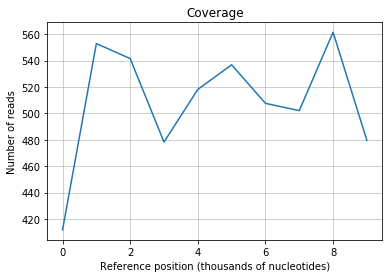

Среднее покрытие: 509.0
Доля покрытой области генома 100.0%


In [186]:
coverage(sam, ref_len)

# 2. Распределение расстояния вставки

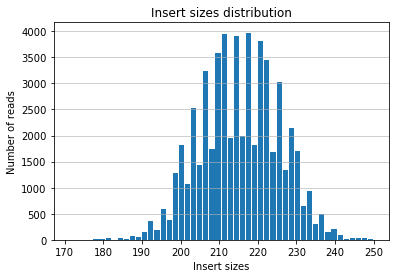

Расстояние вставки
Среднее 215.4
Среднеквадратичное отклонение 10.2
Минимум 171, максимум 250
Интервал, в который попадает 95% [195.0, 235.7]


In [187]:
inserts(sam)

## 3. Частоты различных замен

In [188]:
errors(sam, ref)

,T,G,C,A
T,0.999970,0.000029,8.448886e-07,8.448886e-07
G,0.000012,0.999973,1.463044e-06,1.389892e-05
C,0.000000,0.000017,9.999716e-01,1.184865e-05
A,0.000000,0.000000,0.000000e+00,1.000000e+00



Средний процент ошибок в ридах 0.0021%

Статистика длин инделов
(пусто)

Статистика качества (замена)
Среднее 18.2
Среднеквадратичное отклонение 8.6
Минимум 2, максимум 35
Интервал, в который попадает 95% [1.0, 35.4]

Статистика качества (вставка)
(пусто)


# Датасет 100x

In [178]:
!samtools flagstat 2a/E.coli/100x.sam

5000581 + 0 in total (QC-passed reads + QC-failed reads)
0 + 0 secondary
581 + 0 supplementary
0 + 0 duplicates
4991553 + 0 mapped (99.82% : N/A)
5000000 + 0 paired in sequencing
2500000 + 0 read1
2500000 + 0 read2
4978334 + 0 properly paired (99.57% : N/A)
4983734 + 0 with itself and mate mapped
7238 + 0 singletons (0.14% : N/A)
0 + 0 with mate mapped to a different chr
0 + 0 with mate mapped to a different chr (mapQ>=5)


In [189]:
ref, ref_len, sam = read_data('2a/E.coli/MG1655-K12.fasta', '2a/E.coli/100x.sam')

## 1. Покрытие генома

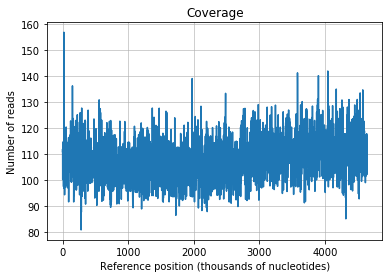

Среднее покрытие: 107.7
Доля покрытой области генома 100.0%


In [190]:
coverage(sam, ref_len)

# 2. Распределение расстояния вставки

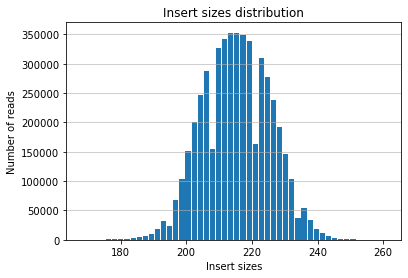

Расстояние вставки
Среднее 215.4
Среднеквадратичное отклонение 10.2
Минимум 168, максимум 261
Интервал, в который попадает 95% [195.0, 235.8]


In [191]:
inserts(sam)

## 3. Частоты различных замен

In [192]:
errors(sam, ref)

,C,A,T,G,_
C,0.989803,0.005152,0.003068,0.001950,0.000026
N,0.249759,0.250346,0.249252,0.250533,0.000110
G,0.001945,0.003084,0.005162,0.989781,0.000028
A,0.002264,0.995186,0.001215,0.001321,0.000014
T,0.001313,0.001212,0.995188,0.002273,0.000014
_,0.225941,0.277672,0.254469,0.241917,0.000000



Средний процент ошибок в ридах 0.8242%

Статистика длин инделов
Среднее 1.2
Среднеквадратичное отклонение 0.8
Минимум 1, максимум 24
Интервал, в который попадает 95% [-0.4, 2.7]

Статистика качества (замена)
Среднее 6.5
Среднеквадратичное отклонение 7.0
Минимум 2, максимум 41
Интервал, в который попадает 95% [-7.5, 20.5]

Статистика качества (вставка)
Среднее 7.2
Среднеквадратичное отклонение 11.1
Минимум 2, максимум 40
Интервал, в который попадает 95% [-15.0, 29.4]

Процент инделов, находящихся рядом с гомополимерными участками 5.2%


# Датасет ecoli_mda_lane1

In [40]:
!samtools flagstat 2a/E.coli/ecoli_mda_lane1_downsampled.sam

5869326 + 0 in total (QC-passed reads + QC-failed reads)
0 + 0 secondary
40560 + 0 supplementary
0 + 0 duplicates
5706946 + 0 mapped (97.23% : N/A)
5828766 + 0 paired in sequencing
2914383 + 0 read1
2914383 + 0 read2
5151500 + 0 properly paired (88.38% : N/A)
5647486 + 0 with itself and mate mapped
18900 + 0 singletons (0.32% : N/A)
0 + 0 with mate mapped to a different chr
0 + 0 with mate mapped to a different chr (mapQ>=5)


In [193]:
ref, ref_len, sam = read_data('2a/E.coli/MG1655-K12.fasta', '2a/E.coli/ecoli_mda_lane1_downsampled.sam')

## 1. Покрытие генома

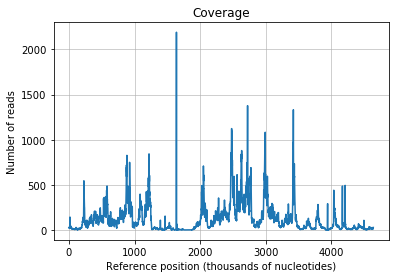

Среднее покрытие: 122.9
Доля покрытой области генома 96.6%


In [194]:
coverage(sam, ref_len)

## 2. Распределение расстояния вставки

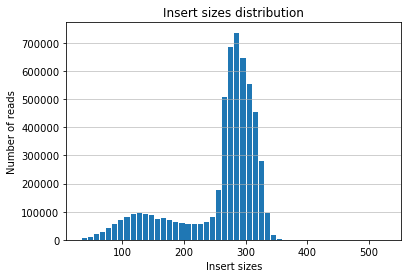

Расстояние вставки
Среднее 258.9
Среднеквадратичное отклонение 66.5
Минимум 33, максимум 529
Интервал, в который попадает 95% [126.0, 391.8]


In [195]:
inserts(sam, 0.9)

## 3. Частоты различных замен

In [196]:
errors(sam, ref)

,T,G,A,C,_
N,0.252287,0.245148,0.255149,0.247251,0.000165
T,0.995515,0.001996,0.001212,0.001258,0.000019
C,0.002764,0.001618,0.004467,0.991124,0.000027
G,0.004456,0.991124,0.002783,0.001615,0.000022
A,0.001214,0.001249,0.995508,0.002011,0.000018
_,0.276247,0.220030,0.279474,0.224249,0.000000



Средний процент ошибок в ридах 0.8110%

Статистика длин инделов
Среднее 1.2
Среднеквадратичное отклонение 0.8
Минимум 1, максимум 34
Интервал, в который попадает 95% [-0.5, 2.8]

Статистика качества (замена)
Среднее 35.5
Среднеквадратичное отклонение 5.8
Минимум 33, максимум 65
Интервал, в который попадает 95% [23.9, 47.1]

Статистика качества (вставка)
Среднее 46.2
Среднеквадратичное отклонение 13.6
Минимум 33, максимум 65
Интервал, в который попадает 95% [19.0, 73.4]

Процент инделов, находящихся рядом с гомополимерными участками 28.7%


**Часть 2: анализ ридов IonTorrent**

# Датасет B22-730

In [197]:
!samtools flagstat 2b/B22-730.sam

497384 + 0 in total (QC-passed reads + QC-failed reads)
0 + 0 secondary
2463 + 0 supplementary
0 + 0 duplicates
489459 + 0 mapped (98.41% : N/A)
0 + 0 paired in sequencing
0 + 0 read1
0 + 0 read2
0 + 0 properly paired (N/A : N/A)
0 + 0 with itself and mate mapped
0 + 0 singletons (N/A : N/A)
0 + 0 with mate mapped to a different chr
0 + 0 with mate mapped to a different chr (mapQ>=5)


In [198]:
ref, ref_len, sam = read_data('2b/DH10B-K12.fasta', '2b/B22-730.sam')

## 1. Покрытие генома

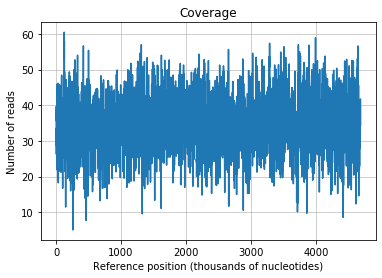

Среднее покрытие: 34.4
Доля покрытой области генома 100.0%


In [199]:
coverage(sam, ref_len)

## 2. Статистика и ошибки

In [200]:
errors(sam, ref)

,A,G,C,T,_
A,0.994483,0.000428,0.000257,0.000281,0.004551
_,0.310631,0.189639,0.188792,0.310938,0.000000
G,0.000599,0.996964,0.000205,0.000229,0.002004
C,0.000231,0.000182,0.996973,0.000618,0.001996
T,0.000278,0.000263,0.000414,0.994459,0.004586



Средний процент ошибок в ридах 0.6680%

Статистика длин инделов
Среднее 1.1
Среднеквадратичное отклонение 0.4
Минимум 1, максимум 24
Интервал, в который попадает 95% [0.3, 1.9]

Статистика качества (замена)
Среднее 19.1
Среднеквадратичное отклонение 8.0
Минимум 1, максимум 45
Интервал, в который попадает 95% [3.1, 35.2]

Статистика качества (вставка)
Среднее 16.1
Среднеквадратичное отклонение 5.9
Минимум 1, максимум 45
Интервал, в который попадает 95% [4.3, 27.8]

Процент инделов, находящихся рядом с гомополимерными участками 9.1%


# Датасет C24-698

In [201]:
!samtools flagstat 2b/C24-698.sam

686667 + 0 in total (QC-passed reads + QC-failed reads)
0 + 0 secondary
1261 + 0 supplementary
0 + 0 duplicates
682638 + 0 mapped (99.41% : N/A)
0 + 0 paired in sequencing
0 + 0 read1
0 + 0 read2
0 + 0 properly paired (N/A : N/A)
0 + 0 with itself and mate mapped
0 + 0 singletons (N/A : N/A)
0 + 0 with mate mapped to a different chr
0 + 0 with mate mapped to a different chr (mapQ>=5)


In [202]:
ref, ref_len, sam = read_data('2b/DH10B-K12.fasta', '2b/C24-698.sam')

## 1. Покрытие генома

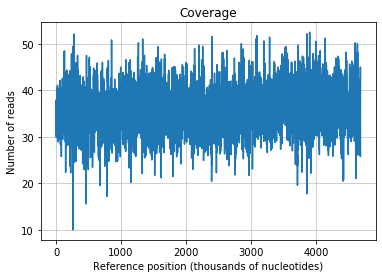

Среднее покрытие: 35.8
Доля покрытой области генома 100.0%


In [203]:
coverage(sam, ref_len)

## 2. Статистика и ошибки

In [204]:
errors(sam, ref)

,A,G,C,T,_
A,0.997410,0.000341,0.000161,0.000157,0.001931
_,0.155514,0.343402,0.343360,0.157725,0.000000
G,0.000525,0.998105,0.000129,0.000126,0.001116
T,0.000155,0.000169,0.000334,0.997393,0.001948
C,0.000122,0.000119,0.998087,0.000536,0.001136



Средний процент ошибок в ридах 0.3675%

Статистика длин инделов
Среднее 1.1
Среднеквадратичное отклонение 0.3
Минимум 1, максимум 26
Интервал, в который попадает 95% [0.4, 1.7]

Статистика качества (замена)
Среднее 21.0
Среднеквадратичное отклонение 8.6
Минимум 1, максимум 45
Интервал, в который попадает 95% [3.9, 38.2]

Статистика качества (вставка)
Среднее 15.4
Среднеквадратичное отклонение 5.1
Минимум 1, максимум 45
Интервал, в который попадает 95% [5.3, 25.5]

Процент инделов, находящихся рядом с гомополимерными участками 5.0%
